In [2]:
import matplotlib.pyplot as plt
from scipy import linalg
import numpy as np
import cv2 as cv
import math

# Singular Value Decomposition 

In [3]:
def sign(number):
    return 1 if (number > 0) else -1
    
def hypotenuse(a, b):
    return math.sqrt(a**2 + b**2)

def isFlipped(matrix):
    row, col = matrix.shape
    return (row < col)

In [4]:
def getEigenRight(mat, eps = 1.e-5):
    mat = np.matrix(mat, dtype=np.float64)
    smat = np.matmul(mat.T, mat)

    # Params
    hess, singularMatrix = linalg.hessenberg(smat, calc_q=True)
    diag = [np.float64(val) for val in np.diag(hess)]
    subdElmt = [np.float64(val) for val in np.diag(hess, -1)]

    # Start
    n = len(diag)
    itermax = 1//eps**2
    subdElmt.append(0)

    for l in range(n):
        j = 0
        while True:
            m = l
            while True:
                # Look for small subdiagonal element
                if (m + 1) == n:
                    break
                # Convergence test
                if abs(subdElmt[m]) <= eps * (abs(diag[m]) + abs(diag[m + 1])):
                    break 
                m += 1
            
            if m == l:
                break 
            
            if j >= itermax:
                raise RuntimeError(f"No convergence to eigenvalue after {j} iteration.")

            j += 1

            # Form shift
            p = diag[l]
            g = (diag[l + 1] - p) / (2 * subdElmt[l])
            r = hypotenuse(g, 1)

            # Avoiding cancelation
            sin = g + sign(g)*r

            g = diag[m] - p + subdElmt[l] / sin

            sin, cos, p = 1, 1, 0

            for i in range(m - 1, l - 1, -1):
                f = sin * subdElmt[i]
                b = cos * subdElmt[i]
                if abs(f) > abs(g):
                    cos = g / f 
                    r = hypotenuse(cos, 1)
                    subdElmt[i + 1] = f * r 
                    sin = 1 / r
                    cos *= sin
                else:
                    sin = f / g if g != 0 else 0
                    r = hypotenuse(sin, 1)
                    subdElmt[i + 1] = g * r 
                    cos = 1 / r 
                    sin *= cos 
                
                g = diag[i + 1] - p 
                r = (diag[i] - g) * sin + 2 * cos * b 
                p = sin * r 
                diag[i + 1] = g + p 
                g = cos * r - b 

                # Compute eigenvectors
                singularMatrix[:, i:i + 2] = singularMatrix[:, i:i + 2]\
                                            .dot(np.array([[cos, sin],
                                                          [-sin, cos]], dtype=np.float64))
 
            diag[l] -= p
            subdElmt[l] = g
            subdElmt[m] = 0

    eigenval = np.array(diag.copy())
    eigenval[np.where(eigenval < 0)] = 0
    sortedIdx = np.argsort(eigenval)[::-1]
    singularMatrix = singularMatrix[:, sortedIdx]
    eigenval = np.sort(eigenval)[::-1]

    return eigenval, singularMatrix

In [5]:
def getSVD(matrix):
    matrix = np.matrix(matrix, dtype=np.float64)
    mcopy = matrix.copy()
    row, col = mcopy.shape

    # Column should be higher than row
    if isFlipped(matrix):
        mcopy = mcopy.T
        row, col = mcopy.shape

    u = np.zeros((row, row))
    eigval, v = getEigenRight(mcopy)

    sigma = np.array([math.sqrt(x) for x in eigval if x != 0])
    maxrank = len(sigma)
    
    # Compute u from v
    for i in range(maxrank):
        u[:, i] = mcopy @ v[:, i] / sigma[i]

    return u, sigma, v, maxrank

In [6]:
def getReducedMatrix(matrix, percent):
    matrix = np.matrix(matrix, dtype=np.float64)
    row, col = matrix.shape
    
    u, sigma, v, maxrank = getSVD(matrix)
    r = math.ceil(percent/100 * maxrank)

    matsig = np.matrix(np.zeros((row, col)), dtype=np.float64)
    np.fill_diagonal(matsig, sigma)
    ui = np.matrix(u[:, :r])
    vi = np.matrix(v.T[:r, :])
    reduced = ui @ matsig[:r, :r] @ vi

    if isFlipped(matrix):
        return reduced.T
    else:
        return reduced

# Read Image

In [10]:
perc = 100
img = cv.imread("lastsupper.jpg", cv.IMREAD_UNCHANGED)
if img.shape[-1] == 4:
    b, g, r, a = cv.split(img)
    reducedRed = getReducedMatrix(r, perc)
    reducedGreen = getReducedMatrix(g, perc)
    reducedBlue = getReducedMatrix(b, perc)
    alpha = np.matrix(a, dtype=np.float64)
    reducedPict = cv.merge((reducedRed, reducedGreen, reducedBlue, alpha)).astype("uint8")
    cv.imwrite("output.png", cv.cvtColor(reducedPict, cv.COLOR_BGRA2RGBA))

elif img.shape[-1] == 3:
    b, g, r = cv.split(img)
    reducedRed = getReducedMatrix(r, perc)
    reducedGreen = getReducedMatrix(g, perc)
    reducedBlue = getReducedMatrix(b, perc)
    reducedPict = cv.merge((reducedRed, reducedGreen, reducedBlue)).astype("uint8")
    cv.imwrite("output.jpg", cv.cvtColor(reducedPict, cv.COLOR_BGRA2RGBA))

else: 
    gray = img.copy()
    reducedPict = getReducedMatrix(gray, perc)
    cv.imwrite("output.jpg", img)

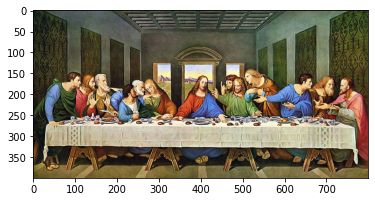

In [11]:
plt.imshow(cv.merge((reducedRed, reducedGreen, reducedBlue)).astype("uint8"))

In [9]:
import os
os.path.isfile("output.jpg")

True